# First things first
* Click **File -> Save a copy in Drive** and click **Open in new tab** in the pop-up window to save your progress in Google Drive.
* Click **Runtime -> Change runtime type** and select **GPU** in Hardware accelerator box to enable faster GPU training.

# (OPTIONAL) Final project: Training VAE

This is an auxiliary notebook that will allow you to train your own VAE on CelebA faces. Note that you may need a modern GPU for training your model in reasonable time. This notebook is <b>not</b> a part of a graded assignment and is done for learners who have access to large computational resources.

### Setup
Load auxiliary files and then install and import the necessary libraries.

In [0]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Downloading Colab files")
    ! shred -u setup_google_colab.py
    ! wget https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.load_data_final_project()

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Lambda, InputLayer, concatenate, Activation, Flatten, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Deconv2D
from keras.losses import MSE
import os
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.utils import np_utils
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
import utils
%matplotlib inline

## Generating faces

For this task you will need to use some database of face images. There are multiple datasets available on the web that you can use: for example, <a href="http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html">CelebA</a> or <a href="http://vis-www.cs.umass.edu/lfw/">Labeled Faces in the Wild</a>. We suggest using Alligned & Cropped version of CelebA that you can find <a href="https://www.dropbox.com/sh/8oqt9vytwxb3s4r/AADSNUu0bseoCKuxuI5ZeTl1a/Img?dl=0&preview=img_align_celeba.zip">here</a>.

In the ZIP archive you will find 202599 colored jpg images of size (218, 178, 3). To read images you can use ```plt.imread``` function. Note that full dataset weights about 1.7G on the disk. You can either read all dataset into memory, or use dataloader from ```utils.py``` that will read images batch-by-batch. Besides preparing batches, our dataloader also crops and rescales input images. 

Example images from dataset are shown below.

In [0]:
data_folder = 'img_align_celeba/'

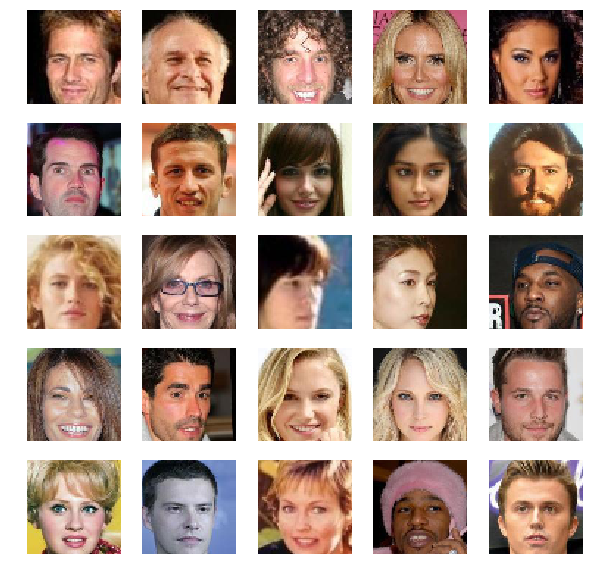

In [0]:
plt.figure(figsize=(10, 10))
for i in range(1, 26):
    filename = os.path.join(data_folder, '{:06d}.jpg'.format(i+3000))
    img = plt.imread(filename)[45:-45:2, 25:-25:2]
    plt.subplot(5, 5, i)
    plt.imshow(img)
    plt.axis('off')

In [0]:
sess = tf.InteractiveSession()
K.set_session(sess)

In [0]:
batch_size=128
latent_size=8

In [0]:
# Avoid running this cell more than once. It may leed to a deadlock
train_images = utils.CelebA(data_folder, sess, batch_size=batch_size)
test_images = utils.CelebA(data_folder, sess, batch_size=batch_size, train=True)
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)

In [0]:
vae, encoder, decoder = utils.create_vae(batch_size=batch_size, latent=latent_size)

In [0]:
K.set_learning_phase(True)

In [0]:
hist = vae.fit_generator(train_images,
                         steps_per_epoch=100,
                         epochs=100,
                         validation_data=test_images,
                         validation_steps=20,
                         verbose=1)

In [0]:
vae.save_weights('CelebA_VAE_small_trained_localy.h5')

In [0]:
### 25 samples
samples = decoder(tf.random_normal((25, latent_size)))
images = sess.run(samples)
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(np.clip(images[i], 0, 1))
    plt.axis('off')
plt.suptitle('Samples', fontsize=20)